### Routing in LangGraph

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond politely. Let me think of a friendly greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s open-ended and invites them to state their needs. I should make sure there are no typos. Yep, looks good. Send it.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 11, 'total_tokens': 89, 'completion_time': 0.191384882, 'prompt_time': 0.002920831, 'queue_time': 0.23801431999999997, 'total_time': 0.194305713}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'stop', 'logprobs': None}, id='run--f6339810-03a1-4f04-b98f-111d499b369b-0', usage_metadata={'input_tokens': 11, 'output_tokens': 78, 'total_tokens': 89})

In [2]:
from typing_extensions import TypedDict,Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field 

In [3]:
### Defining Schema for structured output

def Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(description="The next steo in the routing process")

router = llm.with_structured_output(Route)

In [4]:
### Define state of Graph

class State(TypedDict):
    input:str
    decision:str
    output:str

In [5]:
### Defining the Graph Nodes

def llm_call_1(state: State):
    """Write a story"""
    response = llm.invoke(state["input"])
    return {"output": response.content}

def llm_call_2(state: State):
    """Write a joke"""
    response = llm.invoke(state["input"])
    return {"output": response.content}

def llm_call_3(state: State):
    """Write a poem"""
    response = llm.invoke(state["input"])
    return {"output": response.content}

In [6]:
def llm_call_routing(state:State):
    """Route the input to the correct node"""
    decision = router.invoke(
        [
            SystemMessage(content="You are a routing agent that decides which node to call next based on the input."),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision": decision["step"]}

In [7]:
### Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

In [8]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

router_build = StateGraph(State)
# Add nodes
router_build.add_node("llm_call_1", llm_call_1)
router_build.add_node("llm_call_2", llm_call_2)
router_build.add_node("llm_call_3", llm_call_3)
router_build.add_node("llm_call_routing", llm_call_routing)

In [9]:
# Add edges to connect nodes
router_build.add_edge(START, "llm_call_routing")
router_build.add_conditional_edges(
    "llm_call_routing",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_build.add_edge("llm_call_1", END)
router_build.add_edge("llm_call_2", END)
router_build.add_edge("llm_call_3", END)

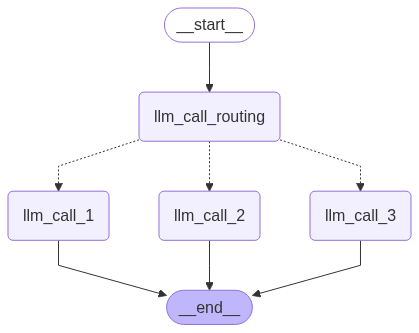

In [10]:
# Compile workflow
router_workflow = router_build.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [12]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])